In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm

### Базовый класс

In [2]:
class BasicAgent:
    '''
    Базовый агент, от которого наследуются стратегии обучения
    '''

    # Наименование алгоритма
    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1):
        # Среда
        self.env = env
        # Размерности Q-матрицы
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        #и сама матрица
        self.Q = np.zeros((self.nS, self.nA))
        # Значения коэффициентов
        # Порог выбора случайного действия
        self.eps=eps
        # Награды по эпизодам
        self.episodes_reward = []

    def print_q(self):
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)
        print(self.Q)

    def get_state(self, state):
        '''
        Возвращает правильное начальное состояние
        '''
        if type(state) is tuple:
            # Если состояние вернулось с виде кортежа, то вернуть только номер состояния
            return state[0]
        else:
            return state

    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        return np.argmax(self.Q[state])

    def make_action(self, state):
        '''
        Выбор действия агентом
        '''
        if np.random.uniform(0,1) < self.eps:

            # Если вероятность меньше eps
            # то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)

    def draw_episodes_reward(self):
        # Построение графика наград по эпизодам
        fig, ax = plt.subplots(figsize = (15,10))
        y = self.episodes_reward
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()

    def learn():
        '''
        Реализация алгоритма обучения
        '''
        pass


### SARSA

In [3]:
class SARSA_Agent(BasicAgent):
    '''
    Реализация алгоритма SARSA
    '''
    # Наименование алгоритма
    ALGO_NAME = 'SARSA'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01

    def learn(self):
        '''
        Обучение на основе алгоритма SARSA
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Выбор действия
            action = self.make_action(state)

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Выполняем следующее действие
                next_action = self.make_action(next_state)

                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)


### Q-обучение

In [4]:
class QLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Q-обучение'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01

    def learn(self):
        '''
        Обучение на основе алгоритма Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Правило обновления Q для SARSA (для сравнения)
                # self.Q[state][action] = self.Q[state][action] + self.lr * \
                #     (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Правило обновления для Q-обучения
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)


### Двойное Q-обучение

In [5]:
class DoubleQLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Double Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Двойное Q-обучение'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Вторая матрица
        self.Q2 = np.zeros((self.nS, self.nA))
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01


    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        temp_q = self.Q[state] + self.Q2[state]
        return np.argmax(temp_q)

    def print_q(self):
        print(f"Вывод Q-матриц для алгоритма {self.ALGO_NAME}")
        print('Q1')
        print(self.Q)
        print('Q2')
        print(self.Q2)

    def learn(self):
        '''
        Обучение на основе алгоритма Double Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                if np.random.rand() < 0.5:
                    # Обновление первой таблицы
                    self.Q[state][action] = self.Q[state][action] + self.lr * \
                        (rew + self.gamma * self.Q2[next_state][np.argmax(self.Q[next_state])] - self.Q[state][action])
                else:
                    # Обновление второй таблицы
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * \
                        (rew + self.gamma * self.Q[next_state][np.argmax(self.Q2[next_state])] - self.Q2[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)


In [6]:
def play_agent(agent):
    '''
    Проигрывание сессии для обученного агента
    '''
    env2 = gym.make('CliffWalking-v0', render_mode='human')
    state = env2.reset()[0]
    done = False
    while not done:
        action = agent.greedy(state)
        next_state, reward, terminated, truncated, _ = env2.step(action)
        env2.render()
        state = next_state
        if terminated or truncated:
            done = True

def run_sarsa():
    env = gym.make('CliffWalking-v0')
    agent = SARSA_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

def run_q_learning():
    env = gym.make('CliffWalking-v0')
    agent = QLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)
    
def run_double_q_learning():
    env = gym.make('CliffWalking-v0')
    agent = DoubleQLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

### SARSA: eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:02<00:00, 7673.73it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ -13.23268491  -12.44924206  -14.14831971  -13.21756225]
 [ -12.45494055  -11.67549393  -13.20950629  -13.4035355 ]
 [ -11.69529513  -10.84139566  -12.57271256  -12.64912424]
 [ -10.87218618   -9.9998437   -11.76705827  -11.90242225]
 [ -10.06010061   -9.1837413   -11.09200247  -11.06105557]
 [  -9.25122716   -8.34921633  -10.17854914  -10.23577852]
 [  -8.38617936   -7.4893919    -9.4211632    -9.53270723]
 [  -7.55922396   -6.60501981   -8.51359079   -8.58745887]
 [  -6.63714748   -5.70849155   -7.68342711   -7.75050899]
 [  -5.77551649   -4.80404568   -5.54444773   -6.83273798]
 [  -4.84843535   -3.88159414   -4.15313036   -5.99035878]
 [  -3.94294948   -3.91932543   -2.9404       -5.05266446]
 [ -13.17392746  -13.34637305  -14.89641159  -13.95140211]
 [ -12.42665153  -16.47657546  -29.01680815  -17.65084815]
 [ -11.66567482  -16.68672111  -20.5102616   -17.8414342 ]
 [ -10.86919026  -15.61148531  -32.42843662  -18.47134339]
 [ -10.15820666  -1

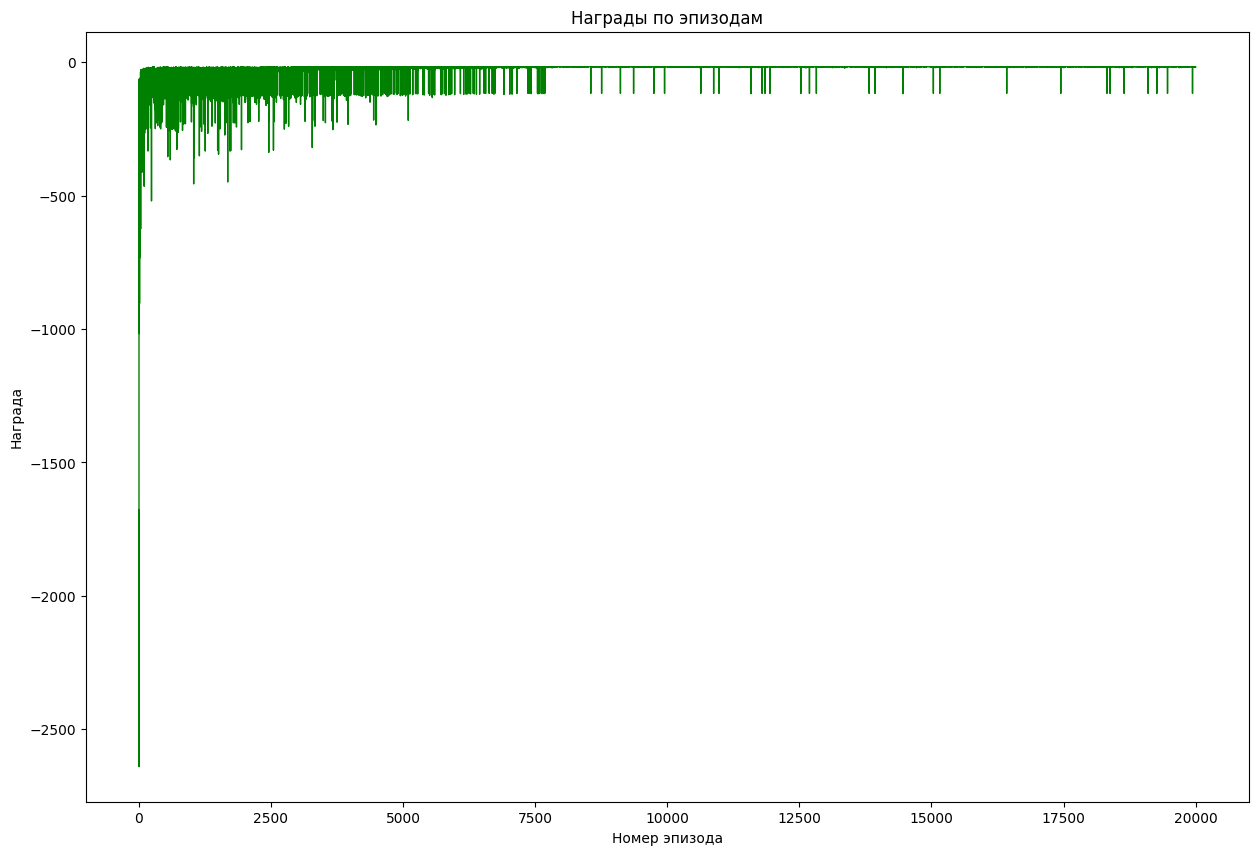

In [7]:
run_sarsa()

### Q-обучение: eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000

100%|██████████| 20000/20000 [00:02<00:00, 7060.42it/s]


Вывод Q-матрицы для алгоритма  Q-обучение
[[ -12.62716012  -12.30066353  -12.30187123  -12.53106295]
 [ -12.07218236  -11.54852805  -11.54851636  -12.11875414]
 [ -11.42779808  -10.76413781  -10.76413919  -12.16847347]
 [ -10.57702507   -9.96342977   -9.96342972  -11.42478967]
 [  -9.9027344    -9.14635907   -9.14635904  -10.7323342 ]
 [  -9.10277569   -8.31261174   -8.31261174   -9.80236621]
 [  -8.29075731   -7.46184883   -7.46184883   -9.13145237]
 [  -7.4603197    -6.59372333   -6.59372333   -8.30611621]
 [  -6.58453374   -5.70788095   -5.70788095   -7.43266689]
 [  -5.69808106   -4.80396016   -4.80396016   -6.54830251]
 [  -4.77048085   -3.881592     -3.881592     -5.67970024]
 [  -3.85517669   -3.74152451   -2.9404       -4.70627397]
 [ -13.03839926  -11.54888054  -11.54888054  -12.31783472]
 [ -12.31686436  -10.76416381  -10.76416381  -12.31789838]
 [ -11.54878676   -9.96343246   -9.96343246  -11.54888044]
 [ -10.76415382   -9.14635966   -9.14635966  -10.76416365]
 [  -9.9634303

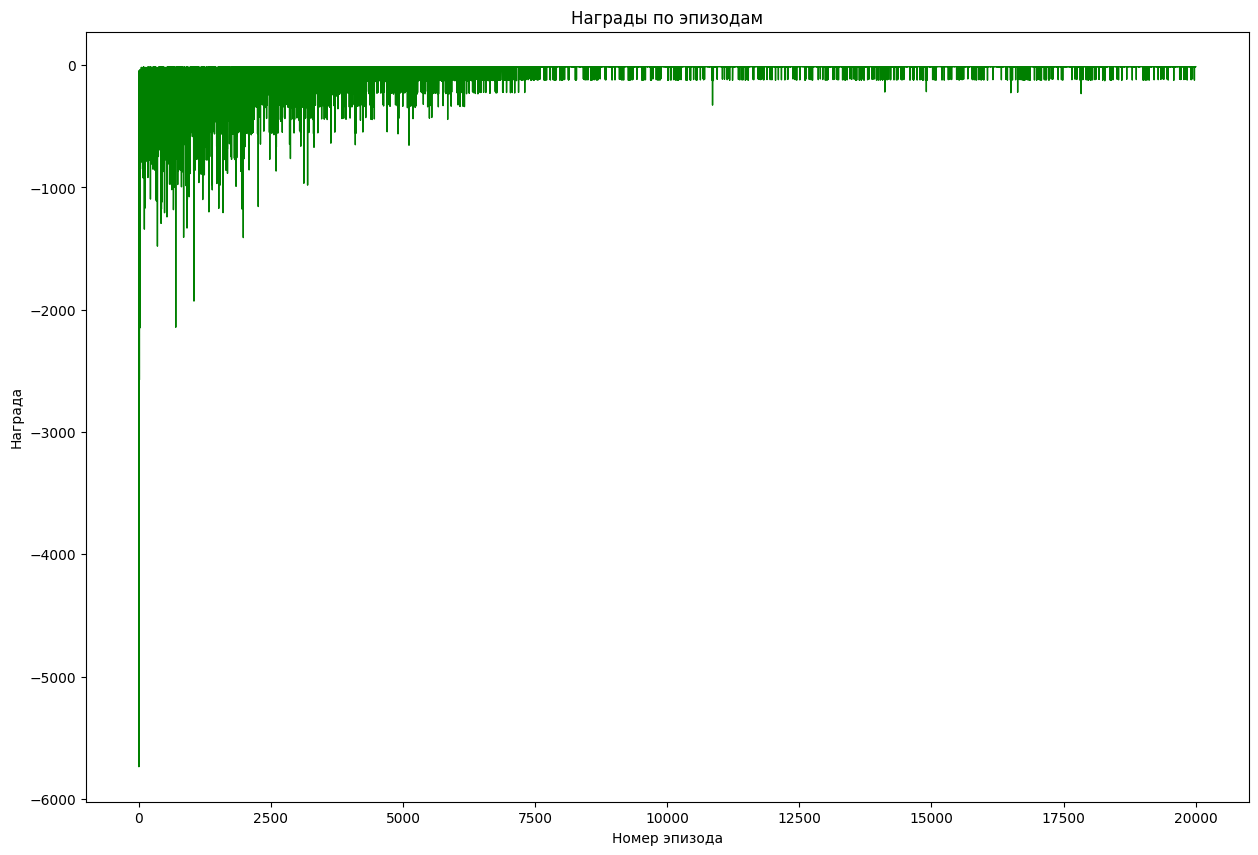

In [8]:
run_q_learning()

### Двойное Q-обучение: eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:02<00:00, 6718.46it/s]


Вывод Q-матриц для алгоритма Двойное Q-обучение
Q1
[[ -15.03480352  -13.96217453  -12.32230003  -14.82268257]
 [ -13.7147303   -13.2499411   -11.54906998  -14.33643105]
 [ -12.81266898  -14.47698313  -10.78932154  -14.66383856]
 [ -13.42803396  -11.47301851  -10.0188274   -12.13172171]
 [ -11.31325571  -10.77256639   -9.14882818  -12.7290895 ]
 [ -11.56242234  -10.65416174   -8.33248595  -11.30154597]
 [ -10.66153285  -10.61448073   -7.59024673  -11.20785512]
 [ -10.2525893    -9.65393915   -6.83089794  -10.31010697]
 [  -9.55535575  -11.34013494   -6.2468964   -10.4420707 ]
 [  -8.88901743   -5.15805226   -5.55624811   -7.49357761]
 [  -4.93387568   -3.90417767   -8.26339178   -8.97559953]
 [  -4.32036073   -4.28170187   -2.94061165   -4.91503919]
 [ -13.13117418  -11.54888054  -11.56698742  -12.34185644]
 [ -12.3192548   -10.76422298  -10.76416381  -12.31810624]
 [ -11.57107435   -9.98597752   -9.96343246  -11.55419573]
 [ -11.17201602   -9.14635966   -9.19267055  -10.79078294]
 [  -

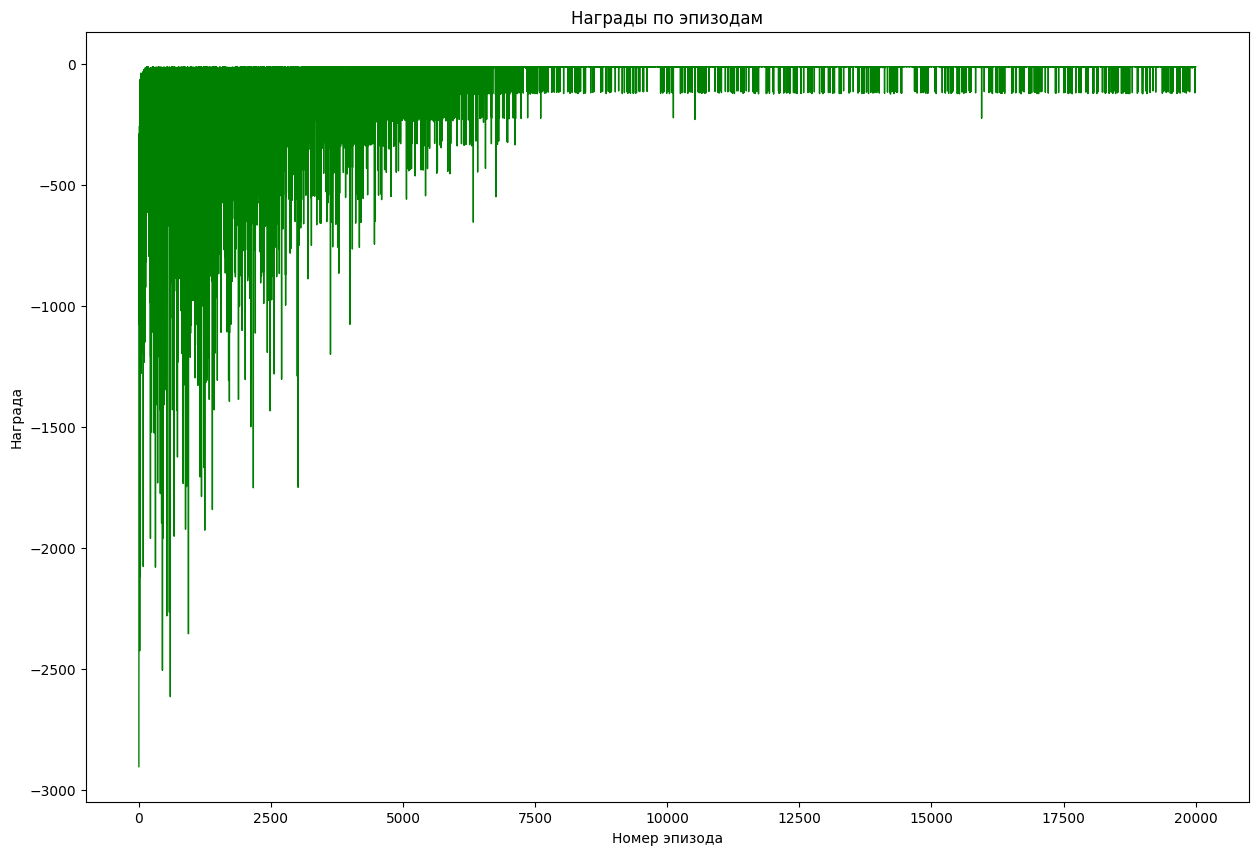

: 

In [9]:
run_double_q_learning()